# ビットコイン相場の変化点検知（BOCPD）

このノートブックでは、ccxtを使ってビットコインの価格データを取得し、BOCPDライブラリで変化点（レジームシフト）を検知します。

## 1. セットアップ

In [23]:
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_fontja
import time
from tqdm.notebook import tqdm
from datetime import datetime, timezone, timedelta

# BOCPDライブラリ
from bocpd import BOCPD, GaussianModel, ConstantHazard
from bocpd.utils import plot_run_length_history

# プロット設定
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 2. ビットコインデータの取得

In [2]:
# Bitget インスタンス作成
bitget = ccxt.bitget()
bitget.load_markets()

print("Bitget接続完了")

Bitget接続完了


In [3]:
# 時刻の設定（JST）
JST = timezone(timedelta(hours=9))

# 今日の JST 0時
today_midnight = datetime.now(JST).replace(hour=0, minute=0, second=0, microsecond=0)
today_unix_ms = int(today_midnight.timestamp()) * 1000

# 7日前の JST 0時
week_ago_midnight = today_midnight - timedelta(days=7)
week_ago_unix_ms = int(week_ago_midnight.timestamp()) * 1000

print("データ取得期間:")
print(f"開始: {week_ago_midnight}")
print(f"終了: {today_midnight}")

データ取得期間:
開始: 2025-12-01 00:00:00+09:00
終了: 2025-12-08 00:00:00+09:00


In [4]:
# ローソク足データ取得（1分足、7日分）
# 1回で720本(12時間分)まで取得可能なので、14回で10080本(7日分)

rows = []
start = week_ago_unix_ms

for i in tqdm(range(14), desc="データ取得中"):
    row = bitget.fetch_ohlcv('BTC/USDT', '1m', since=start, limit=720)
    rows.extend(row)
    start += 43_200_000  # 12時間 = 60*60*12*1000 ms
    time.sleep(1)  # API制限対策

print(f"\n取得データ数: {len(rows)}本")

データ取得中:   0%|          | 0/14 [00:00<?, ?it/s]


取得データ数: 10080本


In [31]:
# DataFrameに変換
df = pd.DataFrame(rows, columns=["Timestamp", "Open", "High", "Low", "Close", "Volume"])
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="ms")
df = df.sort_values("Timestamp").reset_index(drop=True)

# リターンを計算
df["return"] = df["Close"].pct_change()  # 単純リターン
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))  # 対数リターン

# NaN除去
df = df.dropna().reset_index(drop=True)

print(f"データ期間: {df['Timestamp'].min()} ~ {df['Timestamp'].max()}")
print(f"データ数: {len(df)}行")
df.head()

データ期間: 2025-11-30 15:02:00 ~ 2025-12-07 15:00:00
データ数: 10079行


,Timestamp,Open,High,Low,Close,Volume,return,log_return
0,2025-11-30 15:02:00,91444.57,91447.53,91423.16,91423.17,0.541829,-0.000234,-0.000234
1,2025-11-30 15:03:00,91423.17,91431.76,91404.00,91404.01,0.989798,-0.000210,-0.000210
2,2025-11-30 15:04:00,91404.01,91404.01,91401.48,91401.49,0.125447,-0.000028,-0.000028
3,2025-11-30 15:05:00,91401.49,91420.00,91346.00,91346.05,3.080723,-0.000607,-0.000607
4,2025-11-30 15:06:00,91346.05,91346.05,91323.00,91333.93,1.145083,-0.000133,-0.000133


## 3. データの可視化

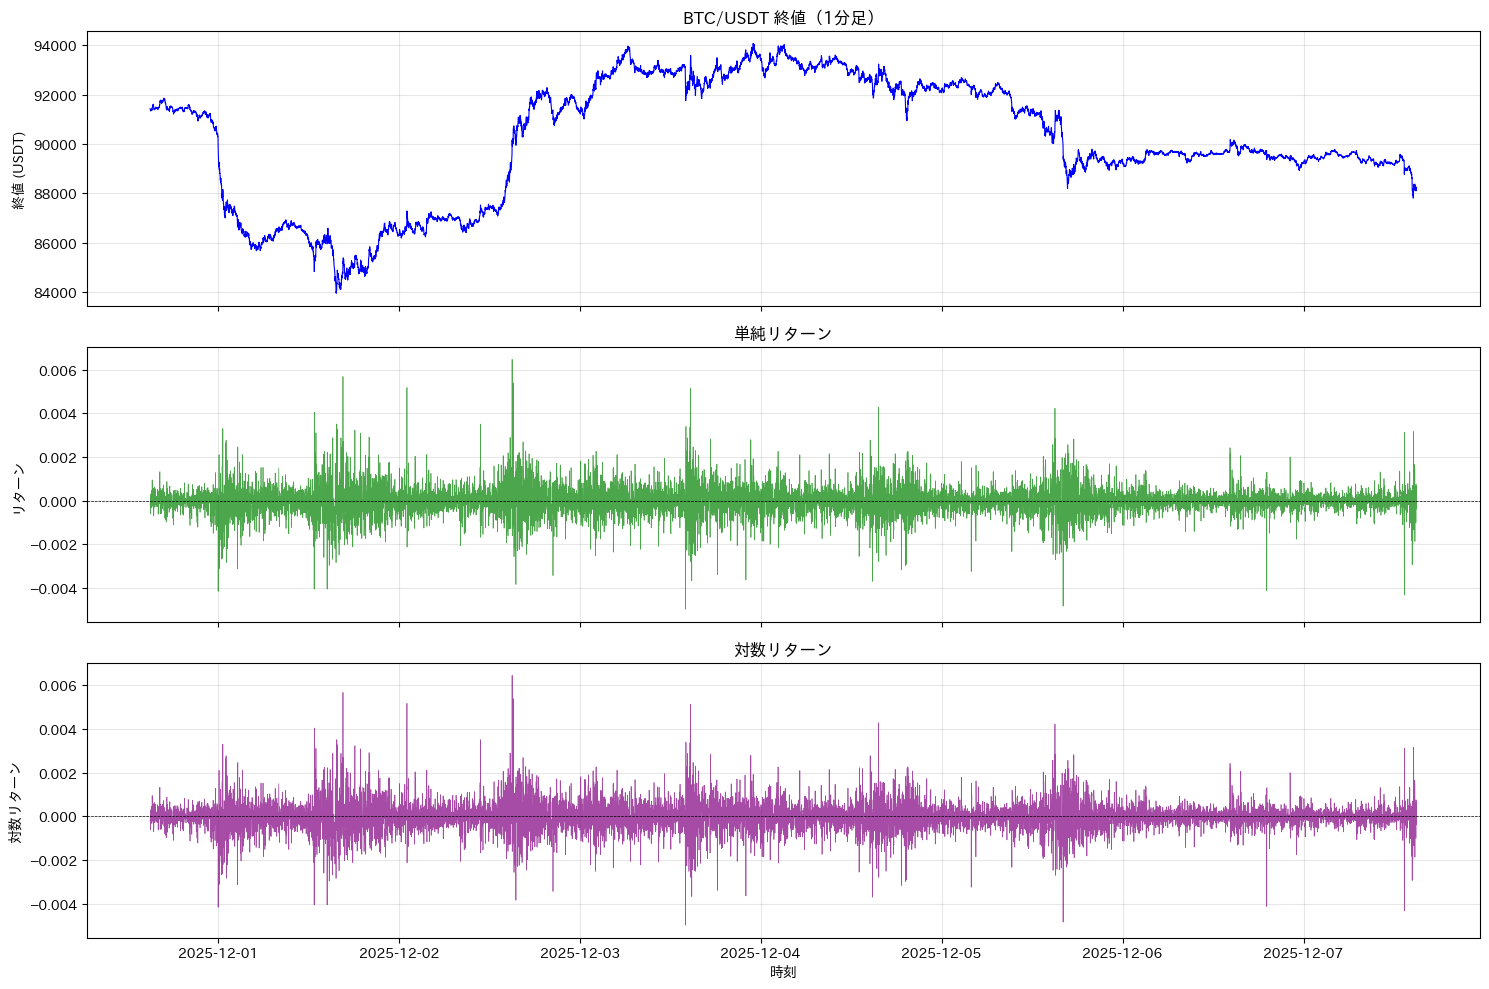


=== 対数リターンの統計量 ===
平均: -0.00000355
標準偏差: 0.00067750
分散: 4.59e-07
最小値: -0.004975
最大値: 0.006443


In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# 終値
axes[0].plot(df["Timestamp"], df["Close"], 'b-', linewidth=0.8)
axes[0].set_ylabel('終値 (USDT)')
axes[0].set_title('BTC/USDT 終値（1分足）')
axes[0].grid(True, alpha=0.3)

# 単純リターン
axes[1].plot(df["Timestamp"], df["return"], 'g-', linewidth=0.5, alpha=0.7)
axes[1].set_ylabel('リターン')
axes[1].set_title('単純リターン')
axes[1].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# 対数リターン
axes[2].plot(df["Timestamp"], df["log_return"], 'purple', linewidth=0.5, alpha=0.7)
axes[2].set_ylabel('対数リターン')
axes[2].set_xlabel('時刻')
axes[2].set_title('対数リターン')
axes[2].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 統計量
print("\n=== 対数リターンの統計量 ===")
print(f"平均: {df['log_return'].mean():.8f}")
print(f"標準偏差: {df['log_return'].std():.8f}")
print(f"分散: {df['log_return'].var():.2e}")
print(f"最小値: {df['log_return'].min():.6f}")
print(f"最大値: {df['log_return'].max():.6f}")

## 4. BOCPD による変化点検知

対数リターンの変化点（ボラティリティや平均の変化）を検知します。

In [9]:
# データ準備
log_returns = df['log_return'].values

# 初期化用データ（最初の720本 = 12時間分）
init_size = 720
init_data = log_returns[:init_size]
stream_data = log_returns[init_size:]

print(f"初期化データ: {len(init_data)}本")
print(f"ストリームデータ: {len(stream_data)}本")

初期化データ: 720本
ストリームデータ: 9359本


In [10]:
# BOCPDモデルの設定
model = GaussianModel()

# ハザード関数の設定
# lambda_ = 1/60 → 期待ランレングス60分（1時間）
hazard = ConstantHazard(lambda_=1/60)

# 検知器の初期化
# max_run_length = 1440 → 24時間分まで追跡
detector = BOCPD(model=model, hazard=hazard, max_run_length=1440)

# 初期データで学習
detector.fit(init_data)

print(f"モデル: {model}")
print(f"ハザード関数: {hazard}")
print(f"最大ランレングス: {detector.max_run_length}分")

モデル: GaussianModel(mu0=-0.0001, kappa0=1.0000, alpha0=2.0000, beta0=0.0000)
ハザード関数: ConstantHazard(lambda_=0.0167, expected_run_length=60.00)
最大ランレングス: 1440分


In [11]:
# オンライン変化点検知
results = {
    'timesteps': [],
    'timestamps': [],
    'values': [],
    'close_prices': [],
    'changepoint_probs': [],
    'run_lengths': [],
    'run_length_dists': [],
    'prediction_log_probs': []
}

detected_changepoints = []

# ストリーミングデータを処理
for i, x in enumerate(tqdm(stream_data, desc="BOCPD実行中")):
    t = init_size + i
    result = detector.update(x)
    
    # 結果を記録
    results['timesteps'].append(t)
    results['timestamps'].append(df['Timestamp'].iloc[t])
    results['values'].append(x)
    results['close_prices'].append(df['Close'].iloc[t])
    results['changepoint_probs'].append(result['changepoint_prob'])
    results['run_lengths'].append(result['most_likely_run_length'])
    results['run_length_dists'].append(result['run_length_dist'])
    results['prediction_log_probs'].append(result['prediction_log_prob'])
    
    # 変化点検知
    run_length = result['most_likely_run_length']
    run_length_dist = result['run_length_dist']
    
    # ランレングス=1で高確率の場合、変化点と判定
    if run_length == 1 and run_length_dist[1] > 0.5:
        detected_changepoints.append(t)

print(f"\n検知された変化点数: {len(detected_changepoints)}")
if len(detected_changepoints) > 0:
    print("\n変化点の時刻（最初の10個）:")
    for cp_idx in detected_changepoints[:10]:
        print(f"  {df['Timestamp'].iloc[cp_idx]}")

BOCPD実行中:   0%|          | 0/9359 [00:00<?, ?it/s]


検知された変化点数: 14

変化点の時刻（最初の10個）:
  2025-12-01 03:02:00
  2025-12-02 08:12:00
  2025-12-02 15:03:00
  2025-12-02 20:28:00
  2025-12-03 14:01:00
  2025-12-03 22:03:00
  2025-12-04 05:12:00
  2025-12-05 03:56:00
  2025-12-06 09:30:00
  2025-12-06 14:15:00


## 5. 結果の可視化

### 5.1 終値と変化点

In [52]:
df_cp = pd.DataFrame.from_dict(results)
df_cp = df_cp[(df_cp["run_lengths"] == 1) & (df_cp["run_length_dists"].apply(lambda x: x[1]) > 0.2)]
df_cp

,timesteps,timestamps,values,close_prices,changepoint_probs,run_lengths,run_length_dists,prediction_log_probs
0,720,2025-12-01 03:02:00,-0.000107,86629.31,0.016667,1,"[0.01666666666666667, 0.983333333333333]",6.342424
689,1409,2025-12-01 14:31:00,-0.004049,85947.38,0.016667,1,"[0.016666666666666687, 0.48567624001210835, 0....",-2.824566
815,1535,2025-12-01 16:37:00,0.005663,85222.09,0.016667,1,"[0.016666666666666687, 0.4205156894905537, 0.0...",-4.384766
1389,2109,2025-12-02 02:11:00,0.002033,86563.00,0.016667,1,"[0.016666666666666656, 0.4007863547204454, 0.1...",-0.025166
1750,2470,2025-12-02 08:12:00,-0.002060,86681.49,0.016667,1,"[0.01666666666666667, 0.6030429228199085, 0.18...",-0.222497
2161,2881,2025-12-02 15:03:00,0.006443,90160.00,0.016667,1,"[0.01666666666666667, 0.5858676514402673, 0.12...",-5.324797
2486,3206,2025-12-02 20:28:00,-0.003429,91054.33,0.016667,1,"[0.01666666666666667, 0.6703323403416085, 0.12...",-2.396070
2585,3305,2025-12-02 22:07:00,-0.001758,91667.00,0.016667,1,"[0.01666666666666667, 0.2343822863994987, 0.09...",1.265460
2707,3427,2025-12-03 00:09:00,0.001811,91460.00,0.016667,1,"[0.01666666666666667, 0.32992692477010477, 0.1...",0.555925
3184,3904,2025-12-03 08:06:00,-0.002223,92971.00,0.016667,1,"[0.01666666666666667, 0.24892231449348784, 0.0...",0.382003


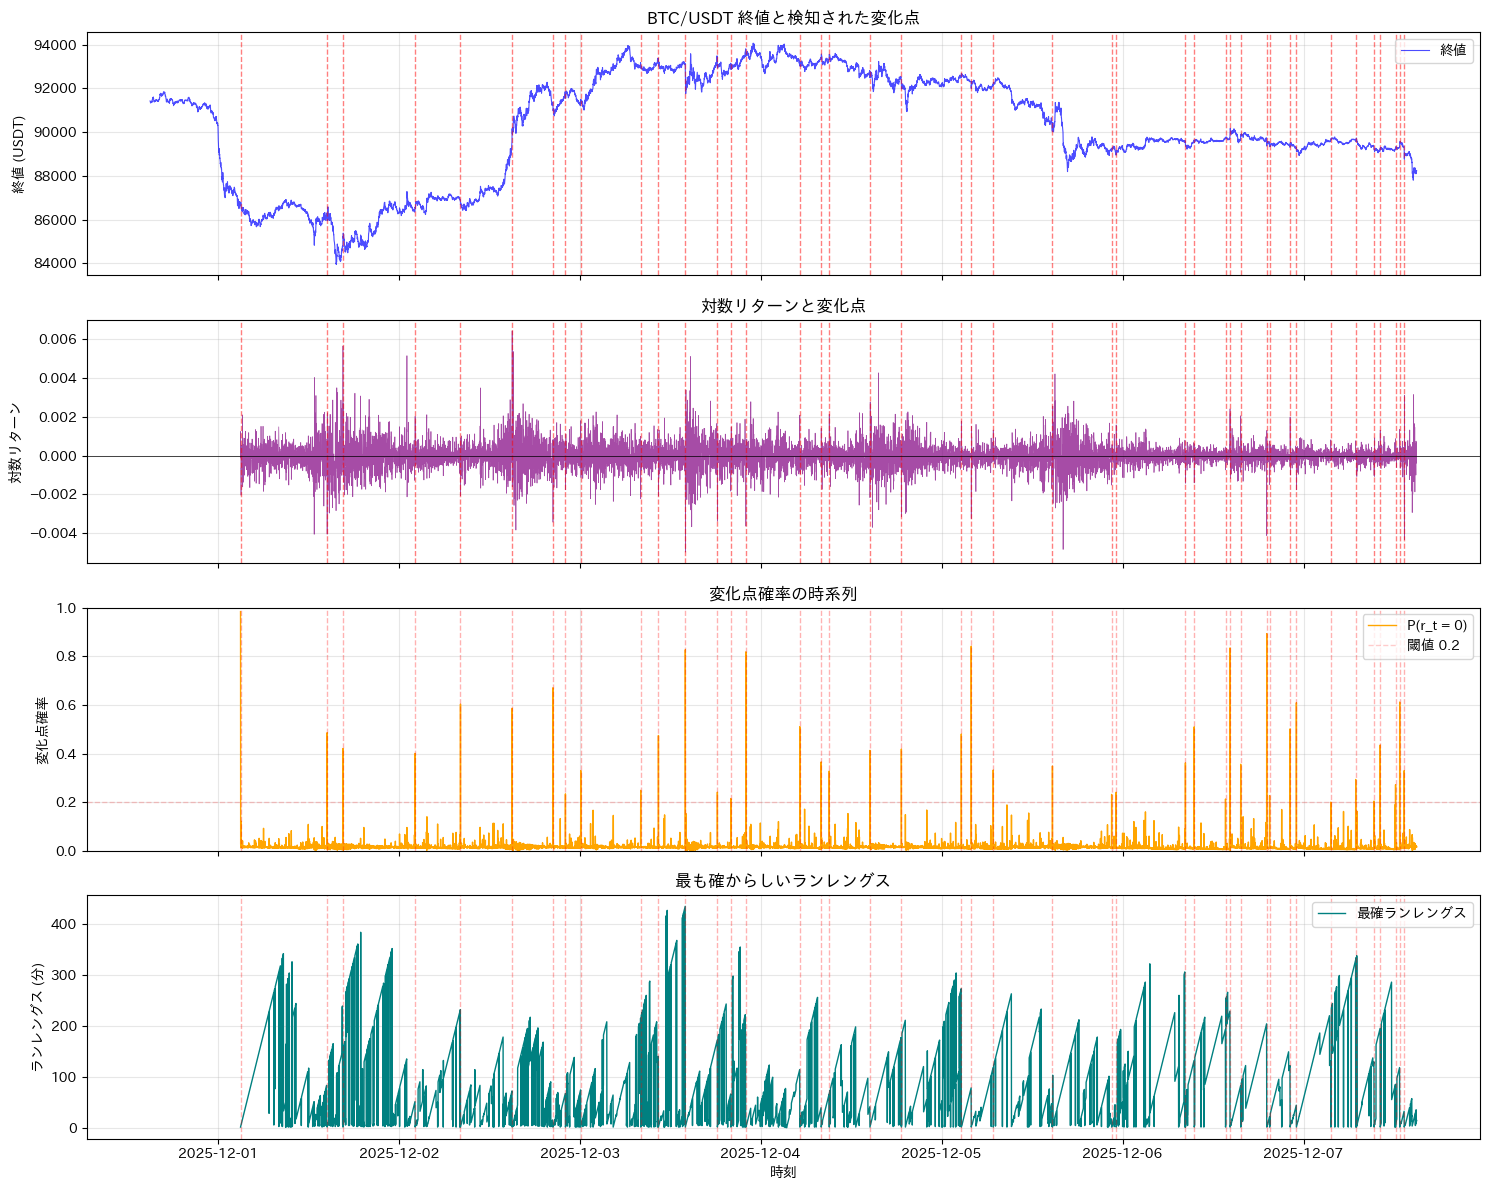

In [58]:
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# プロット1: 終値と変化点
axes[0].plot(df['Timestamp'], df['Close'], 'b-', linewidth=0.8, alpha=0.7, label='終値')
for i, row in df_cp.iterrows():
    t = row["timestamps"]
    axes[0].axvline(t, color='r', linestyle='--', linewidth=1, 
                    alpha=0.5, label='変化点' if cp == detected_changepoints[0] else '')
axes[0].set_ylabel('終値 (USDT)')
axes[0].set_title('BTC/USDT 終値と検知された変化点')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# プロット2: 対数リターン
axes[1].plot(results['timestamps'], results['values'], 'purple', linewidth=0.5, alpha=0.7)
for i, row in df_cp.iterrows():
    t = row["timestamps"]
    axes[1].axvline(t, color='r', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(0, color='k', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('対数リターン')
axes[1].set_title('対数リターンと変化点')
axes[1].grid(True, alpha=0.3)

# プロット3: 変化点確率
dists = list(map(lambda x: x[1], results['run_length_dists']))
axes[2].plot(results['timestamps'], dists, 'orange', linewidth=1, label='P(r_t = 0)')
axes[2].axhline(0.2, color='red', linestyle='--', linewidth=1, alpha=0.2, label='閾値 0.2')
for i, row in df_cp.iterrows():
    t = row["timestamps"]
    axes[2].axvline(t, color='r', linestyle='--', linewidth=1, alpha=0.3)
axes[2].set_ylabel('変化点確率')
axes[2].set_title('変化点確率の時系列')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])

# プロット4: 最も確からしいランレングス
axes[3].plot(results['timestamps'], results['run_lengths'], 'teal', linewidth=1, label='最確ランレングス')
for i, row in df_cp.iterrows():
    t = row["timestamps"]
    axes[3].axvline(t, color='r', linestyle='--', linewidth=1, alpha=0.3)
axes[3].set_xlabel('時刻')
axes[3].set_ylabel('ランレングス (分)')
axes[3].set_title('最も確からしいランレングス')
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 ランレングス分布のヒートマップ

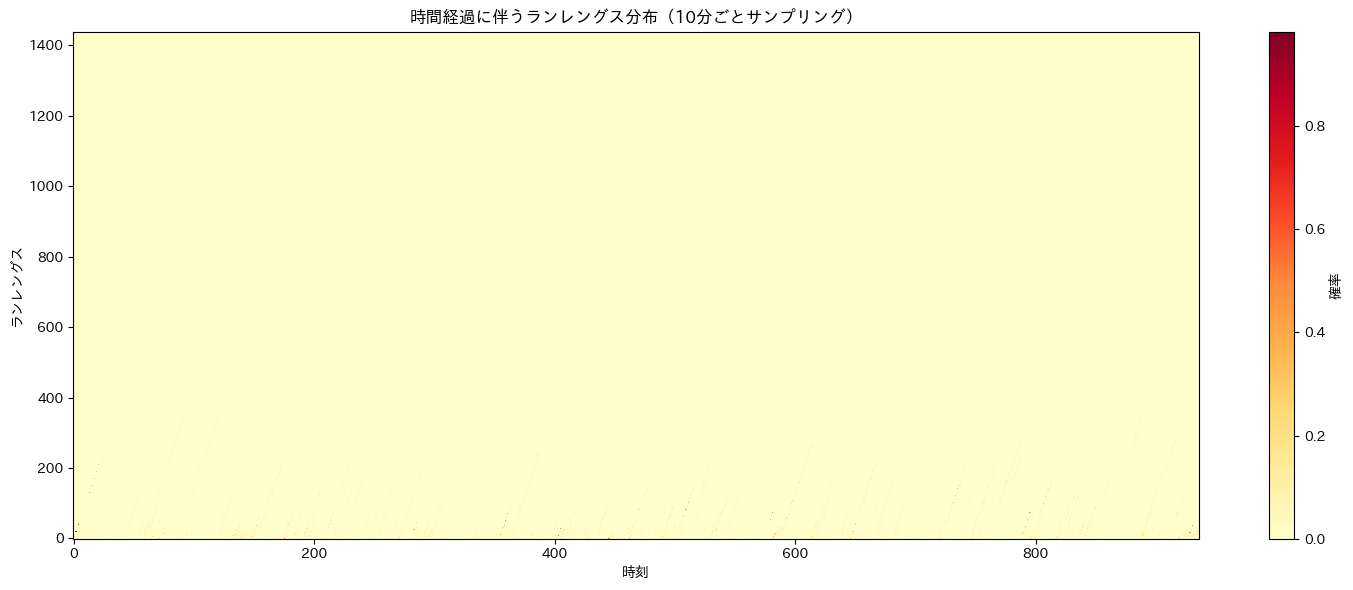

In [13]:
# ランレングス分布のヒートマップ（サブサンプリングして表示）
# 全データだと重いので、10分ごとにサンプリング
subsample = 10
run_length_dists_subset = results['run_length_dists'][::subsample]

fig = plot_run_length_history(
    run_length_dists_subset,
    figsize=(15, 6),
    title='時間経過に伴うランレングス分布（10分ごとサンプリング）'
)
plt.show()

### 5.3 予測対数確率

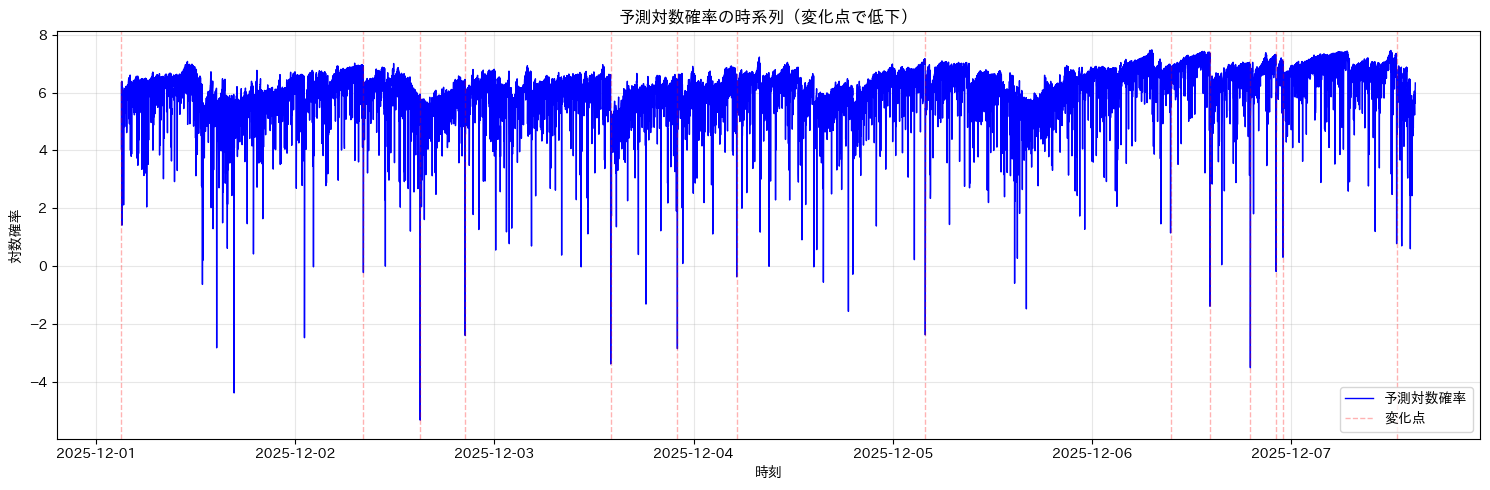

平均負の対数尤度: -6.064830


In [14]:
plt.figure(figsize=(15, 5))
plt.plot(results['timestamps'], results['prediction_log_probs'], 'b-', linewidth=1, label='予測対数確率')
for cp in detected_changepoints[:50]:
    plt.axvline(df['Timestamp'].iloc[cp], color='r', linestyle='--', linewidth=1, 
                alpha=0.3, label='変化点' if cp == detected_changepoints[0] else '')
plt.xlabel('時刻')
plt.ylabel('対数確率')
plt.title('予測対数確率の時系列（変化点で低下）')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 平均負の対数尤度
mean_nll = -np.mean(results['prediction_log_probs'])
print(f"平均負の対数尤度: {mean_nll:.6f}")

## 6. 変化点周辺の詳細分析

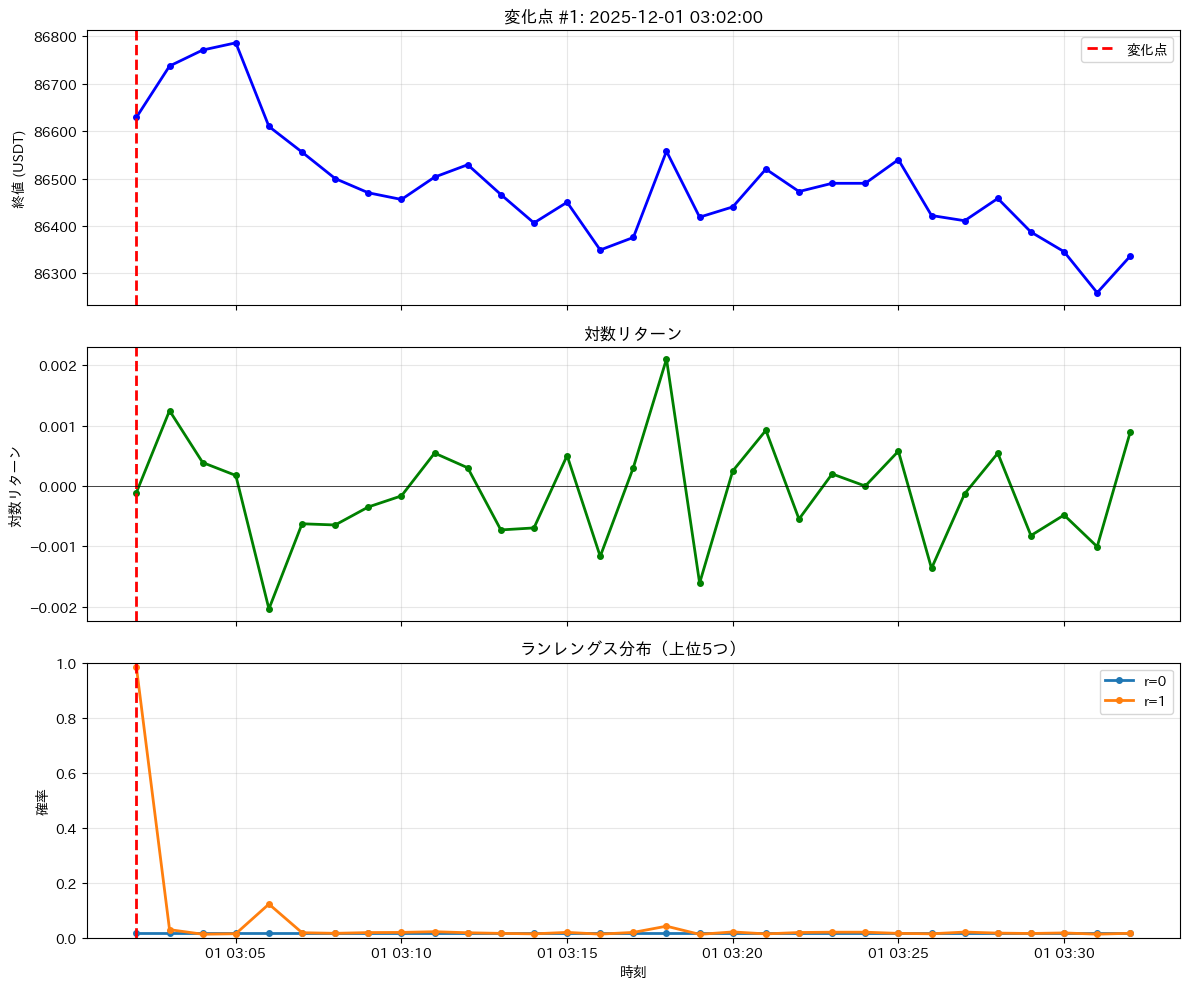

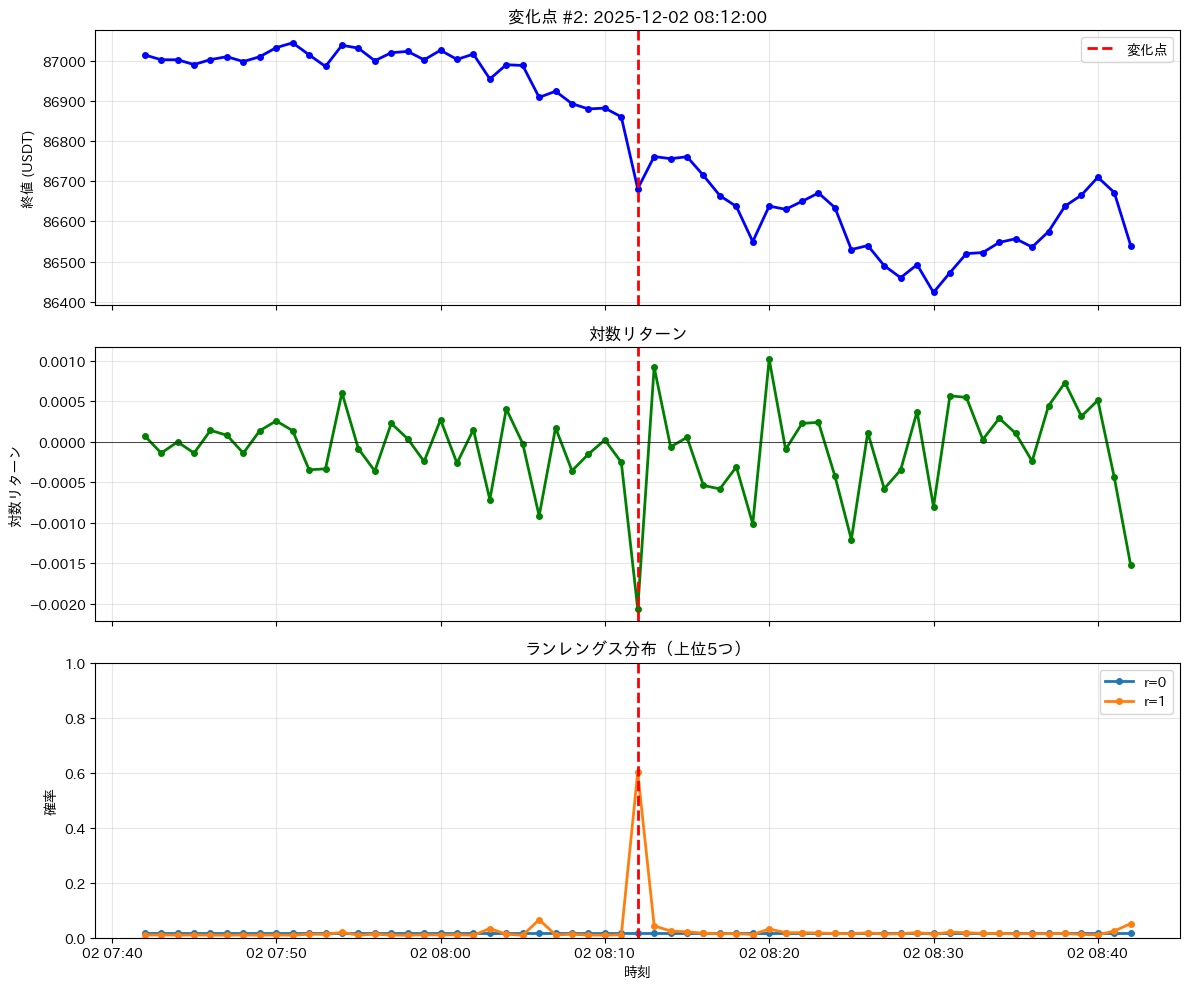

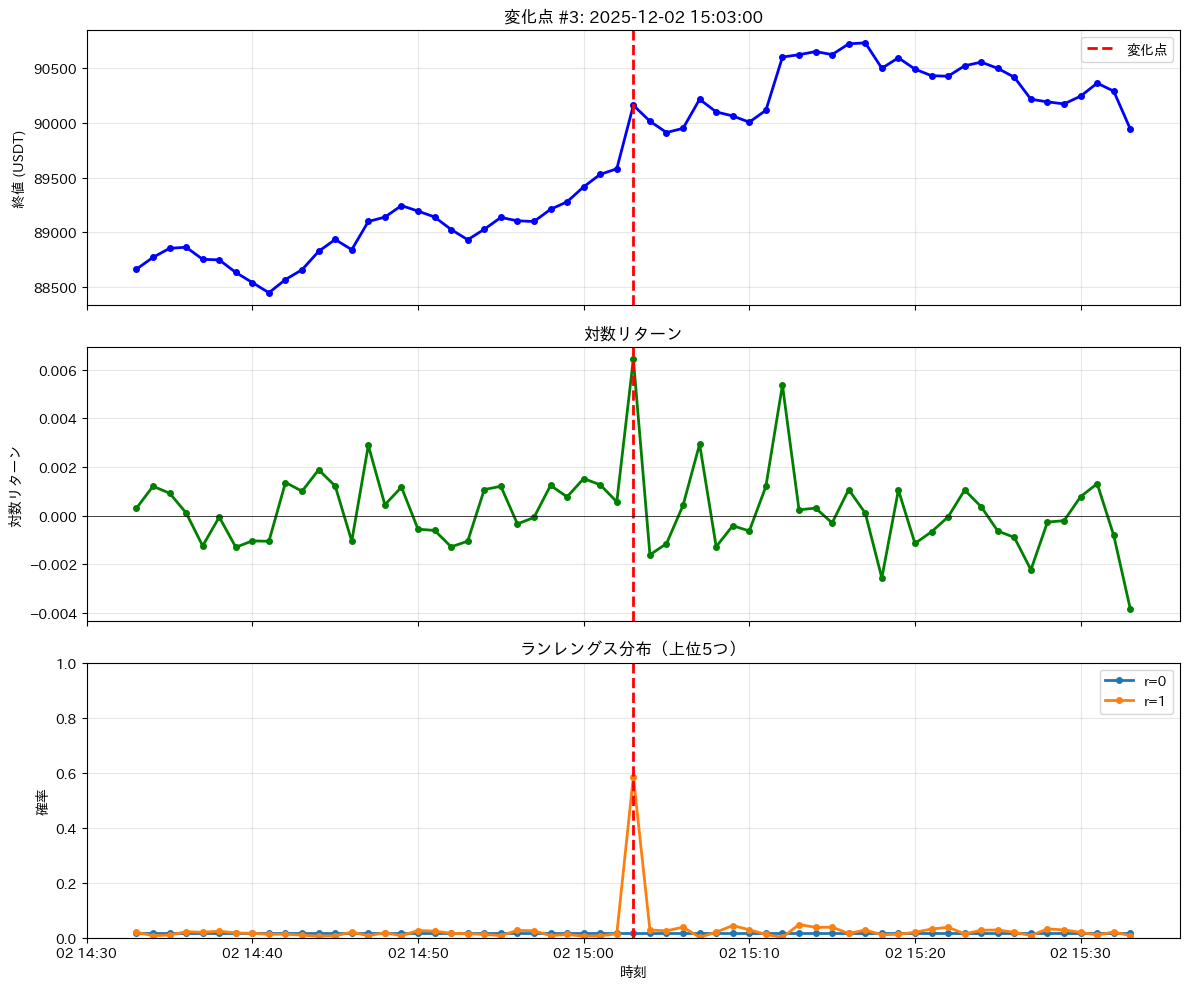

In [15]:
def plot_changepoint_detail(df, results, changepoint_idx, window=30, title="変化点周辺の詳細"):
    """変化点周辺の詳細をプロット"""
    # resultsのインデックスに変換（init_size分のオフセット）
    init_size = 720
    result_idx = changepoint_idx - init_size
    
    if result_idx < 0 or result_idx >= len(results['timesteps']):
        print(f"変化点インデックス {changepoint_idx} は範囲外です")
        return
    
    # ウィンドウ範囲
    start_idx = max(0, result_idx - window)
    end_idx = min(len(results['timesteps']), result_idx + window + 1)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # プロット1: 終値
    window_times = results['timestamps'][start_idx:end_idx]
    window_close = results['close_prices'][start_idx:end_idx]
    axes[0].plot(window_times, window_close, 'bo-', linewidth=2, markersize=4)
    axes[0].axvline(results['timestamps'][result_idx], color='r', linestyle='--', linewidth=2, label='変化点')
    axes[0].set_ylabel('終値 (USDT)')
    axes[0].set_title(title)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # プロット2: 対数リターン
    window_values = results['values'][start_idx:end_idx]
    axes[1].plot(window_times, window_values, 'go-', linewidth=2, markersize=4)
    axes[1].axvline(results['timestamps'][result_idx], color='r', linestyle='--', linewidth=2)
    axes[1].axhline(0, color='k', linestyle='-', linewidth=0.5)
    axes[1].set_ylabel('対数リターン')
    axes[1].set_title('対数リターン')
    axes[1].grid(True, alpha=0.3)
    
    # プロット3: ランレングス分布（上位5つ）
    for r in range(min(5, len(results['run_length_dists'][0]))):
        probs = [dist[r] if r < len(dist) else 0 for dist in results['run_length_dists'][start_idx:end_idx]]
        axes[2].plot(window_times, probs, 'o-', linewidth=2, markersize=4, label=f'r={r}')
    
    axes[2].axvline(results['timestamps'][result_idx], color='r', linestyle='--', linewidth=2)
    axes[2].set_xlabel('時刻')
    axes[2].set_ylabel('確率')
    axes[2].set_title('ランレングス分布（上位5つ）')
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

# 最初の3つの変化点を詳しく見る
for i, cp in enumerate(detected_changepoints[:3]):
    timestamp = df['Timestamp'].iloc[cp]
    plot_changepoint_detail(df, results, cp, window=30, 
                           title=f'変化点 #{i+1}: {timestamp}')

## 7. 統計サマリー

In [16]:
print("=" * 60)
print("BOCPD 変化点検知サマリー")
print("=" * 60)
print(f"データ期間: {df['Timestamp'].min()} ~ {df['Timestamp'].max()}")
print(f"総データ数: {len(df)}本 (1分足)")
print(f"\n初期化データ: {init_size}本 ({init_size/60:.1f}時間)")
print(f"処理データ: {len(stream_data)}本 ({len(stream_data)/60:.1f}時間)")
print(f"\nハザード率 λ: {hazard.lambda_:.4f}")
print(f"期待ランレングス: {1/hazard.lambda_:.1f}分")
print(f"最大ランレングス: {detector.max_run_length}分 ({detector.max_run_length/60:.1f}時間)")
print(f"\n検知された変化点数: {len(detected_changepoints)}")
print(f"変化点検知率: {len(detected_changepoints) / len(stream_data) * 100:.2f}%")

if len(detected_changepoints) > 1:
    intervals = np.diff(detected_changepoints)
    print(f"\n変化点間隔の統計:")
    print(f"  平均: {intervals.mean():.1f}分")
    print(f"  中央値: {np.median(intervals):.1f}分")
    print(f"  最小: {intervals.min()}分")
    print(f"  最大: {intervals.max()}分")

print("\n" + "=" * 60)

BOCPD 変化点検知サマリー
データ期間: 2025-11-30 15:02:00 ~ 2025-12-07 15:00:00
総データ数: 10079本 (1分足)

初期化データ: 720本 (12.0時間)
処理データ: 9359本 (156.0時間)

ハザード率 λ: 0.0167
期待ランレングス: 60.0分
最大ランレングス: 1440分 (24.0時間)

検知された変化点数: 14
変化点検知率: 0.15%

変化点間隔の統計:
  平均: 709.5分
  中央値: 429.0分
  最小: 50分
  最大: 1774分



## 8. ハザード率の影響を確認

異なるハザード率で変化点検知の感度がどう変わるか確認します。

In [17]:
# 異なるハザード率で実験
lambda_values = [1/30, 1/60, 1/120, 1/240]  # 期待ランレングス: 30分, 1時間, 2時間, 4時間

comparison_results = {}

for lambda_ in lambda_values:
    print(f"\nλ = {lambda_:.4f} (期待ランレングス: {1/lambda_:.0f}分) で実行中...")
    
    model = GaussianModel()
    hazard = ConstantHazard(lambda_=lambda_)
    detector = BOCPD(model=model, hazard=hazard, max_run_length=1440)
    detector.fit(init_data)
    
    changepoints = []
    
    for i, x in enumerate(stream_data):
        result = detector.update(x)
        run_length = result['most_likely_run_length']
        run_length_dist = result['run_length_dist']
        
        if run_length == 1 and run_length_dist[1] > 0.5:
            changepoints.append(init_size + i)
    
    comparison_results[lambda_] = changepoints
    print(f"  検知された変化点数: {len(changepoints)}")

# 結果の比較プロット
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Close'], 'b-', linewidth=0.8, alpha=0.5, label='終値')

colors = ['red', 'orange', 'green', 'purple']
for (lambda_, cps), color in zip(comparison_results.items(), colors):
    for cp in cps[:30]:  # 最初の30個のみ
        plt.axvline(df['Timestamp'].iloc[cp], color=color, linestyle='--', 
                   linewidth=1, alpha=0.4, 
                   label=f'λ={lambda_:.4f} ({len(cps)}個)' if cp == cps[0] else '')

plt.xlabel('時刻')
plt.ylabel('終値 (USDT)')
plt.title('ハザード率による変化点検知の違い')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


λ = 0.0333 (期待ランレングス: 30分) で実行中...


KeyboardInterrupt: 

## まとめ

このノートブックでは：

1. ccxtを使ってBitcoinの1分足データを取得
2. 対数リターンを計算
3. BOCPDで変化点（レジームシフト）を検知
4. ランレングス分布、変化点確率、予測対数確率を可視化
5. ハザード率の影響を分析

を行いました。BOCPDは価格の統計的性質（平均やボラティリティ）の変化を自動的に検知できます。